In [1]:
from matplotlib import pyplot as plt

In [2]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'/Users/juanhernandez/Development/NWU-Pacific/NWU-Pacific/')

In [3]:
df_topics = pd.read_hdf('/Users/juanhernandez/Documents/NWU/data/topics.hdf', 'topics')

In [4]:
df_orig = pd.read_csv('/Users/juanhernandez/Downloads/consumer_complaints.csv')

In [5]:
df_vectors = pd.read_hdf('/Users/juanhernandez/Documents/NWU/data/vectors.hdf', 'vectors')

In [6]:
df = pd.merge(df_orig, df_topics, on='Complaint ID', how='inner')

In [7]:
df = pd.merge(df, df_vectors, on='Complaint ID', how='inner')

In [8]:
df=df[df['Company public response'].isnull()==False]

In [9]:
df['Company public response'].unique()

array(['Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company believes the complaint is the result of a misunderstanding',
       'Company believes it acted appropriately as authorized by contract or law',
       "Company can't verify or dispute the facts in the complaint",
       'Company chooses not to provide a public response',
       'Company believes complaint represents an opportunity for improvement to better serve consumers',
       'Company believes complaint caused principally by actions of third party outside the control or direction of the company',
       'Company disputes the facts presented in the complaint',
       'Company believes complaint is the result of an isolated error',
       'Company believes complaint relates to a discontinued policy or procedure'],
      dtype=object)

In [55]:
# label = 'Company believes complaint represents an opportunity for improvement to better serve consumers' 
label = 'Company disputes the facts presented in the complaint'
y = (df['Company public response']==label).astype(int)

In [56]:
X_topics = pd.DataFrame(df['topics'].values.tolist(), columns = ['topic_{}'.format(k) for k in range(1,21)])
V = len(df['vectors'].iloc[0])
X_vectors = pd.DataFrame(df['vectors'].values.tolist(), columns = ['vector_{}'.format(k) for k in range(1,V+1)])

In [57]:
X = pd.concat([X_vectors, X_topics], axis=1)
X = X_topics

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## train RF

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', n_estimators=200)

In [62]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [63]:
y_hat_test = model.predict_proba(X_test)[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
test_auc = roc_auc_score(y_test, y_hat_test)
y_hat_train = model.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat_train)
train_auc = roc_auc_score(y_train, y_hat_train)

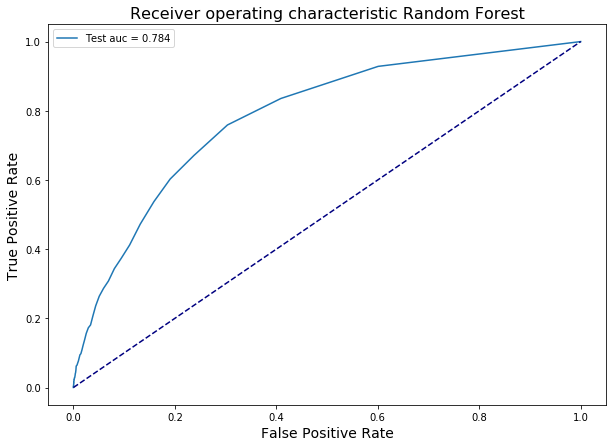

In [64]:
plt.figure(figsize=(10,7))
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic Random Forest', fontsize=16)
plt.plot(fpr_test, tpr_test, label='Test auc = {:.3f}'.format(test_auc))
# plt.plot(fpr_train, tpr_train, label='Train auc = {:.3f}'.format(train_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()
plt.show()

## train xgb

In [65]:
from xgboost import XGBClassifier

In [66]:
model = XGBClassifier(njobs=-1, nthread=-1, scale_pos_weight=1/y.mean(), objective='binary:logistic')

In [67]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, njobs=-1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=63.7156704361874, seed=None, silent=True,
       subsample=1)

In [68]:
y_hat_test = model.predict_proba(X_test)[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
test_auc = roc_auc_score(y_test, y_hat_test)
y_hat_train = model.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat_train)
train_auc = roc_auc_score(y_train, y_hat_train)

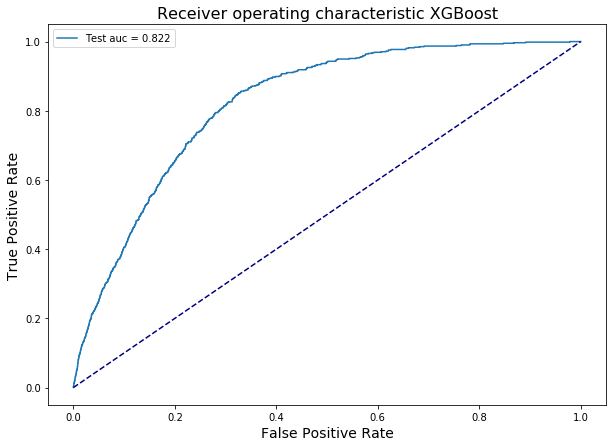

In [69]:
plt.figure(figsize=(10,7))
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic XGBoost', fontsize=16)
plt.plot(fpr_test, tpr_test, label='Test auc = {:.3f}'.format(test_auc))
# plt.plot(fpr_train, tpr_train, label='Train auc = {:.3f}'.format(train_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()
plt.show()

## optimize xgb

In [81]:
from sklearn.model_selection import  GridSearchCV, StratifiedKFold

In [99]:
model = XGBClassifier(njobs=-1, nthread=-1, objective='binary:logistic')
parameters = {
              'learning_rate': [0.01],
              'scale_pos_weight': [1, 10, 1/y.mean()],
              'max_depth': [5, 10, 20],
              'n_estimators': [750] 
}


clf = GridSearchCV(model, parameters, n_jobs=2, 
                   cv=StratifiedKFold(n_splits=3, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed: 72.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, njobs=-1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'scale_pos_weight': [1, 10, 63.7156704361874], 'n_estimators': [750], 'learning_rate': [0.01], 'max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [100]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=750,
       n_jobs=1, njobs=-1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [103]:
model = clf.best_estimator_
y_hat_test = model.predict_proba(X_test)[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
test_auc = roc_auc_score(y_test, y_hat_test)
y_hat_train = model.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat_train)
train_auc = roc_auc_score(y_train, y_hat_train)

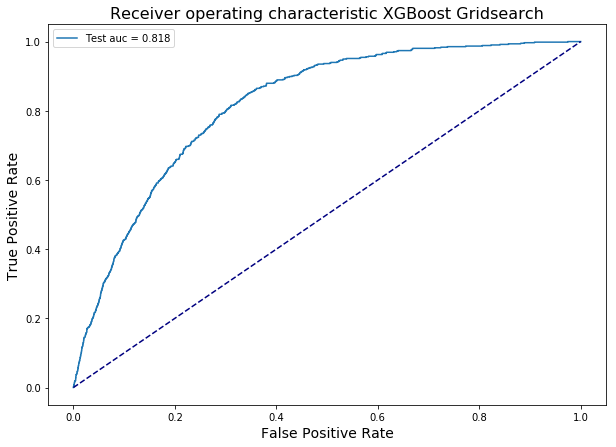

In [104]:
plt.figure(figsize=(10,7))
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic XGBoost Gridsearch', fontsize=16)
plt.plot(fpr_test, tpr_test, label='Test auc = {:.3f}'.format(test_auc))
# plt.plot(fpr_train, tpr_train, label='Train auc = {:.3f}'.format(train_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()
plt.show()